In [311]:
import argparse
import time
import torch
from Models import get_model
from Process import *
import torch.nn.functional as F
from Optim import CosineWithRestarts
from Batch import create_masks
import pdb
import dill as pickle
import argparse
from Models import get_model
from Beam import beam_search
from nltk.corpus import wordnet
from torch.autograd import Variable
import re
from Batch import nopeak_mask
import math
import numpy as np
from pathlib import Path
import subprocess
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from Models import Transformer
from translation.translator import Translator
from translation.query import *
from sklearn.feature_extraction.text import TfidfVectorizer
os.chdir("/mnt/nfs/work1/allan/smsarwar/material/pytorch_transformer/")

In [312]:
def tokenizer(text):  # create a tokenizer function
    return text.split()

def create_fields(opt):
    #print("loading tokenizers...")
    SRC = pickle.load(open(f'{opt.load_vocab}/SRC.pkl', 'rb'))
    TRG = pickle.load(open(f'{opt.load_vocab}/TRG.pkl', 'rb'))
    return (SRC, TRG)

def evaluate():
    # Check current working directory.
    # retval = os.getcwd()
    os.chdir("CLEF-ENG-ML/")
    p = subprocess.Popen(
        '/cm/shared/apps/java/jdk1.8.0_191/bin/java -cp target/lib/*:target/CLEF-ENG-ML-1.0-SNAPSHOT.jar rabflair.flair.myBatchSearch',
        shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    
    line = p.stdout.readlines()[0]
    line_splitted = line.decode().split()
    mAP = float(line_splitted[3])
    os.chdir("../")
    print("MAP:\t" + str(mAP))
    
parser = argparse.ArgumentParser()
#If we are working on small dataset
small = 0
#If we want to activate relevance based training
relevance_training = 1
if small==1:
    parser.add_argument('-src_data', type=str, default='data/italian_small.txt')
    parser.add_argument('-trg_data', type=str, default='data/english_small.txt')
    parser.add_argument('-trg_data_retrieval', type=str, default='data/english_retrieval.txt')

else:
    parser.add_argument('-src_data', type=str, default='data/italian.txt')
    parser.add_argument('-trg_data', type=str, default='data/english.txt')
    parser.add_argument('-trg_data_retrieval', type=str, default='data/LATIMESTEXT2.txt')

parser.add_argument('-src_lang', type=str, default='it')
parser.add_argument('-trg_lang', type=str, default='en')
parser.add_argument('-no_cuda', action='store_true')
parser.add_argument('-SGDR', action='store_true')
parser.add_argument('-epochs', type=int, default=2)
parser.add_argument('-d_model', type=int, default=200)
parser.add_argument('-n_layers', type=int, default=6)
parser.add_argument('-heads', type=int, default=8)
parser.add_argument('-dropout', type=int, default=0.1)
parser.add_argument('-batchsize', type=int, default=1500)
parser.add_argument('-printevery', type=int, default=100)
parser.add_argument('-lr', type=int, default=0.0001)
parser.add_argument('-load_weights', type=str, default='weights')
parser.add_argument('-load_vocab', type=str, default='clir_it_en')
#parser.add_argument('-load_weights', type=str, default='tiny_train')
parser.add_argument('-create_valset', action='store_true')
parser.add_argument('-max_strlen', type=int, default=80)
parser.add_argument('-floyd', action='store_true')
parser.add_argument('-checkpoint', type=int, default=0)


_StoreAction(option_strings=['-checkpoint'], dest='checkpoint', nargs=None, const=None, default=0, type=<class 'int'>, choices=None, help=None, metavar=None)

In [313]:
opt = parser.parse_args(args=[])

raw_data = {'trg': [line for line in open(opt.trg_data)]} ###  
raw_data_retrieval = {'trg': [line for line in open(opt.trg_data_retrieval)]}
# print(len(raw_data['trg']))    
# print(len(raw_data_retrieval['trg']))    
# vectorizer_europarl = TfidfVectorizer(use_idf=True)
# vectorizer_europarl.fit_transform(raw_data['trg'])
# tokens_europarl = vectorizer_europarl.get_feature_names()

# vectorizer_clef = TfidfVectorizer(use_idf=True)
# vectorizer_clef.fit_transform(raw_data_retrieval['trg'])
# tokens_clef = vectorizer_clef.get_feature_names()

#idf_values = vectorizer.idf_
    

In [314]:
tokens_europarl_dict = {}
tokens_clef_dict = {} 
for line in open(opt.trg_data):
    for token in line.split():
        tokens_europarl_dict.setdefault(token.strip(), 1)

for line in open(opt.trg_data_retrieval):
    for token in line.split():
        tokens_clef_dict.setdefault(token.strip(), 1)
        



In [315]:
tokens_europarl = tokens_europarl_dict.keys()
tokens_clef = tokens_clef_dict.keys()
tokens_union = tokens_europarl | tokens_clef
tokens_intersection = tokens_europarl & tokens_clef 
tokens_only_europarl = tokens_europarl - tokens_intersection
tokens_only_clef = tokens_clef - tokens_intersection


print("size of europarl token set")
print(len(tokens_europarl))
print("size of clef token set")
print(len(tokens_clef))
print("size of intersection of the tokens")
print(len(tokens_intersection))
print("size of union of the tokens")
print(len(tokens_union))
print("size of only clef token set")
print(len(tokens_only_clef))
print("size of only europarl token set")
print(len(tokens_only_europarl))


def query_term_vocabulary_distribution(query):
    #print(len(tokens_only_europarl))
    #print(len(tokens_only_clef))
    #print(query)
    
    query = query.strip()
    query_splitted = query.split()
    query_splitted_set = set(query_splitted)
    print (query_splitted_set)
    count_only_europarl = 0.0
    count_only_clef = 0.0
    count_others = 0.0
    count_intersection = 0.0
    for term in query_splitted_set:
        #print (term)
        if term in tokens_only_europarl:
            count_only_europarl+=1
        elif term in tokens_only_clef:
            count_only_clef+=1
            print("clef term\t" + term)
        elif term in tokens_intersection:
            count_intersection+=1
        else:
            count_others+=1
            
    print("count only europarl\t" + str(count_only_europarl))
    print("count only clef\t" + str(count_only_clef))
    print("count intersection\t" + str(count_intersection))
    print("count others\t" + str(count_others))
    
    #print("count only europarl\t" + str(count_only_europarl/len(query_splitted_set)))
    #print("count only clef\t" + str(count_only_clef/len(query_splitted_set)))
    #print("count intersection\t" + str(count_intersection/len(query_splitted_set)))
    #print("count others\t" + str(count_others/len(query_splitted_set)))
    


size of europarl token set
77441
size of clef token set
214767
size of intersection of the tokens
51918
size of union of the tokens
240290
size of only clef token set
162849
size of only europarl token set
25523


In [316]:
from sklearn.feature_extraction.text import CountVectorizer

print("creating dataset and iterator... ")
print(opt.trg_data)

translation_data = [line for line in open(opt.trg_data)] ###
raw_data = {'trg': translation_data} ###  
raw_data_retrieval = {'trg': [line for line in open(opt.trg_data_retrieval)]}

europarl_dict = {}
clef_dict = {}

for line in open(opt.trg_data): 
    line_splitted = line.split()
    for token in line_splitted: 
        token_stripped = token.strip() 
        if token_stripped in europarl_dict: 
            europarl_dict[token_stripped] = europarl_dict[token_stripped] + 1
        else:
            europarl_dict[token_stripped] = 1

for line in open(opt.trg_data_retrieval): 
    line_splitted = line.split()
    for token in line_splitted: 
        token_stripped = token.strip() 
        if token_stripped in clef_dict: 
            clef_dict[token_stripped] = clef_dict[token_stripped] + 1
        else:
            clef_dict[token_stripped] = 1


creating dataset and iterator... 
data/english.txt


In [317]:
total_frequency_clef = 0
total_frequency_europarl = 0

for key in europarl_dict.keys():
    total_frequency_europarl+= europarl_dict[key]

for key in clef_dict.keys():
    total_frequency_clef+= clef_dict[key]
print (total_frequency_clef)
print (total_frequency_europarl)

34613470
25134641


In [326]:
def query_term_distribution(query):
    #print(len(tokens_only_europarl))
    #print(len(tokens_only_clef))
    #print(query)    
    query = query.strip()
    query_splitted = query.split()
    query_splitted_set = set(query_splitted)
    query_vocab_ditribution = {}
    for term in query_splitted_set:
        europarl_element = 0 
        if term.strip() in europarl_dict: 
            europarl_element = europarl_dict[term.strip()]
        clef_element = 0
        if term.strip() in clef_dict: 
            clef_element = clef_dict[term.strip()]
        
        query_vocab_ditribution[term.strip()] = [europarl_element * 10000 / total_frequency_europarl , clef_element * 10000 / total_frequency_clef]
    europarl = 0.0
    clef = 0.0
    top_europarl = []
    ratio = 0.0
    number_of_terms = 0
    number_of_discarded_terms = 0
    for key in query_vocab_ditribution.keys():
        europarl= query_vocab_ditribution[key][0]
        clef= query_vocab_ditribution[key][1]
        if clef == 0:
            clef = 1            
        if europarl/clef < 100:
            ratio+= europarl/clef
            number_of_terms+=1
        else:
            number_of_discarded_terms+=1 
        top_europarl.append((key, query_vocab_ditribution[key][0], query_vocab_ditribution[key][1]))
        
    top_europarl = sorted(top_europarl, key = lambda x: x[1], reverse=True)
    top_europarl = top_europarl[0:1]        
    #print (number_of_discarded_terms)
    if number_of_terms == 0: 
        number_of_terms = 1
    return query_vocab_ditribution, ratio/number_of_terms, top_europarl

import torch
import torch.nn as nn
from Layers import EncoderLayer, DecoderLayer
from Embed import Embedder, PositionalEncoder
from Sublayers import Norm
import copy

def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(EncoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)
    def forward(self, src, mask):
        x = self.embed(src)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, mask)
        return self.norm(x)

class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(DecoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)
    def forward(self, trg, e_outputs, src_mask, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)

class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads, dropout):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads, dropout)
        self.decoder = Decoder(trg_vocab, d_model, N, heads, dropout)
        self.out = nn.Linear(d_model, trg_vocab)
    def forward(self, src, trg, src_mask, trg_mask):
        e_outputs = self.encoder(src, src_mask)
        #print("DECODER")
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output

def get_model(opt, src_vocab, trg_vocab):

    assert opt.d_model % opt.heads == 0
    assert opt.dropout < 1

    model = Transformer(src_vocab, trg_vocab, opt.d_model, opt.n_layers, opt.heads, opt.dropout)

    if opt.load_weights is not None:
        print("loading pretrained weights...")
        model.load_state_dict(torch.load(f'{opt.load_weights}/model_weights'))
    else:
        for p in model.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    if opt.device == 0:
        model = model.cuda()


os.chdir("/mnt/nfs/work1/allan/smsarwar/material/pytorch_transformer/")
opt.device = 0 if opt.no_cuda is False else -1
opt.max_len = 100
CONTEXT_SIZE = 2    
#print(opt)
SRC, TRG = create_fields(opt)
# opt.train = create_dataset(opt, SRC, TRG)
translator = Translator(SRC, TRG)

model_dict = {"N(MT)+":"so_far_best_validation", "NMT":"mw_sum_relevance_translation/model_weights_best_validation", "current":"model_weights", "no_relevance": "so_far_best_validation"}
config = {"model": model_dict["N(MT)+"],  
"source_cat" : False,  #original query concatenated into source
"source_cat_frequency" : 2,  #2 is default, if want to concatenate more increase this value
"target_cat" : False,    #original query concatenated into target
"target_cat_frequency" : 2, 
"query_type" : "squery", 
"galago_query" : False,
"rm" : False,
"rm_weight" : 0.80,
"k" : 1, 
"query_expansion" : False,
"number_of_expansion_terms" : 1, 
"nqueries": 50, 
"verbose": False}

transformer_queries = []
for line in open("transformer.txt"):
    transformer_queries.append(line.strip())


#for rm_weight in np.linspace(0.85, 1, 5):
for rm_weight in [0.5]:
    config['rm_weight'] = rm_weight
    if config["query_expansion"] == False:
        config["rm"] = False

    opt.k = config["k"]

    #model = Transformer(len(SRC.vocab), len(TRG.vocab), opt.d_model, opt.n_layers, opt.heads, opt.dropout, 2)
    model = Transformer(len(SRC.vocab), len(TRG.vocab), opt.d_model, opt.n_layers, opt.heads, opt.dropout)
    #src_vocab, trg_vocab, opt.d_model, opt.n_layers, opt.heads, opt.dropout
    
    model = model.cuda()
    model_str = f'{opt.load_weights}/' + config["model"]   
    model.load_state_dict(torch.load(model_str)) 
    # Order in which queries are put: title, title_description, description
    # load italian queries
    eng_query_dict = translator.load_query_file("CLEF-ENG-ML/index/english/all", "All-eng-tit-final.tsv", "All-eng-tit-des-final-clef.tsv")
    it_query_dict = translator.load_query_file("CLEF-ENG-ML/index/italian", "All-Top-ita-tit-final.txt",
                                    "All-Top-ita-tit-desc-final.txt")
    it_query_tt_dict = translator.load_query_tt("CLEF-ENG-ML/index/italian", "italian_tt_temp.txt")
    translation_file = open(os.path.join("CLEF-ENG-ML/index/english/all", "All-eng-tit-des-final.tsv"), "w")

    sum_percentage_uncovered = 0.0
    clef_term_dict = {}
    nqueries = 0.0
    europarl_vocab = 0.0
    clef_vocab = 0.0
    ratio_global = 0.0
    start = 50
    precision = 0.0
    recall = 0.0 
    for key in sorted(it_query_dict)[start:]: #config["nqueries"]]:
        opt.text = it_query_dict[key][1]  ###    
        original_query = opt.text 
        #tt_query = it_query_tt_dict[opt.text]     
        opt.text = opt.text.replace("trova", " ")
        opt.text = opt.text.replace("documenti", " ")
        opt.text = opt.text.replace("trovino", " ")    
        opt.text = opt.text.replace("riguardano", " ")        
        if config["source_cat"] == True:
            opt.text = " ".join([original_query] * config["source_cat_frequency"])

        candidate, queries, query_tokens = translator.translate(opt, model, SRC, TRG)     
        candidate = transformer_queries[start + int(nqueries)]
        candidate = candidate.replace("favourable", "")
        if config["query_type"] == "dquery":
            if config["galago_query"] == True:
                candidate = create_galago_query(queries[0], "")
            else:
                candidate = ' '.join(queries[0].keys()) ###    
        else:
            candidate = candidate.lower() 
            if len(candidate) == 0:
                candidate = opt.text
            
        candidate_splitted = candidate.split()        
        
        #print (candidate_splitted)
        window_size = CONTEXT_SIZE * 2 + 1
        
        if len(candidate_splitted) == 0: 
            candidate_splitted = opt.text.split()
        
        while len(candidate_splitted) < window_size:  #if the length of the translation is so small not to fit in a window
            #candidate_splitted+= candidate_splitted[0: (window_size - (len(candidate_splitted)))] 
            candidate_splitted.append(candidate_splitted[0])
            
        #print (candidate_splitted)
        
        
#         tt = torch.LongTensor([[TRG.vocab.stoi[token] for token in candidate_splitted]]).cuda()            

#         data_context_final = []
#         data_target_final = []
                
#         for element in tt: 
#             #print(element)
#             #idx = torch.randperm(element.nelement())
#             #corpus_text = element.view(-1)[idx].view(element.size())
#             corpus_text = element
#             for i in range(CONTEXT_SIZE, len(corpus_text) - CONTEXT_SIZE):
#                 data_context = []
#                 data_target = []
#                 for j in range(CONTEXT_SIZE):
#                     data_context.append(corpus_text[i - CONTEXT_SIZE + j])
#                 for j in range(1, CONTEXT_SIZE + 1):
#                     data_context.append(corpus_text[i + j])

#                 data_target.append(corpus_text[i])
#                 #data.append((data_context, data_target))
#                 data_context_final.append(torch.LongTensor(data_context))
#                 data_target_final.append(torch.LongTensor(data_target))

#         data_context_final = torch.stack(data_context_final).cuda()
#         data_target_final = torch.stack(data_target_final).cuda()        
#         src = torch.randn(5, 7, dtype=torch.double)
#         trg_input = torch.randn(5, 7, dtype=torch.double)
#         src_mask = torch.randn(5, 7, dtype=torch.double)
#         trg_mask = torch.randn(5, 7, dtype=torch.double)

#         preds_emb = model(src, trg_input, src_mask, trg_mask, data_context_final)
#         probs, ix = preds_emb.data.topk(config["number_of_expansion_terms"])
#         preds_token_ids = ix.view(ix.size(0), -1)    
#         preds_token_probs = probs.view(ix.size(0), -1)    
#         preds_strings = ' '.join([' '.join([TRG.vocab.itos[ind] for ind in ex]) for ex in preds_token_ids])
#         preds_strings_with_probs = [(TRG.vocab.itos[ex[0]], math.exp(ex[1].item())) for ex in zip(preds_token_ids, preds_token_probs)]
#         preds_strings = " ".join([tuple[0] for tuple in sorted(preds_strings_with_probs, key = lambda x: x[1], reverse=False)[0:15]])

#         query_rm = "#combine:" 
#         for idx, item in enumerate(preds_strings_with_probs):
#             query_rm+= str(idx) + "=" + str(item[1]) + ":"
#         query_rm = query_rm[0:-1] + "(" 
#         for idx, item in enumerate(preds_strings_with_probs):
#             query_rm+= str(item[0]) + " "
#         query_rm = query_rm.strip() + ")"            
        if config["target_cat"] == True:            
            candidate = candidate + " " + " ".join([original_query] * config["target_cat_frequency"])

        if config["query_expansion"] == True:    
            if config["rm"] == False:
                candidate = candidate + " " + preds_strings

        #print (preds_emb)    
        reference = eng_query_dict[key][1]  ###    
        if config["verbose"] == True:
            print("**********************************************************************")    
            print("source query")
            print(opt.text)
            print("**********************************************************************")    
            print("reference translation")
            print(reference)    
            print("**********************************************************************")
            print("candidate translation")
            print(candidate)
            print("**********************************************************************")    
            print("expansion terms")
            print(preds_strings)
            print("**********************************************************************")    
            print("candidate vocabulary distribution")
            query_term_vocabulary_distribution(candidate)
            print("**********************************************************************")    
            print("query vocabulary distribution")
            term_distribution, query_term_ratio, topk_europarl = query_term_distribution(candidate)
            print(term_distribution)
            europarl_vocab+= topk_europarl[0][1]
            clef_vocab+= topk_europarl[0][2]
            ratio_global += query_term_ratio
            print (query_term_ratio)
            print(topk_europarl)
            print("**********************************************************************")    
            print("expansion terms vocabulary distribution")
            query_term_vocabulary_distribution(preds_strings)            
            #uery_term_vocabulary_distribution(candidate)
            print("**********************************************************************")

        term_distribution, query_term_ratio, topk_europarl = query_term_distribution(candidate)            
        #print (query_term_ratio)
            
        reference_splitted = set(reference.split())
        candidate_splitted = set(candidate.split())
        covered = candidate_splitted.intersection(reference_splitted)
        precision+=(1.0 *len(covered))/len(candidate_splitted)
        recall+=(1.0 *len(covered))/len(reference_splitted)
        uncovered = reference_splitted.difference(candidate_splitted)
        percentage_uncovered = len(uncovered) / (len(reference_splitted) * 1.0)
        sum_percentage_uncovered += percentage_uncovered
        covered = reference_splitted.difference(uncovered)
        str_uncovered = ' '.join(uncovered)
        str_covered = ' '.join(covered)  

        if config["rm"] == True:
            #preds_strings = query_rm
            translation_file.write(key + "\t" + "#combine:0=" + str(config["rm_weight"])+ ":1=" + str(1-config["rm_weight"]) + "(#combine(" + candidate + ") #combine(" + preds_strings + "))\n")
        else:  
            translation_file.write(key + "\t" + candidate +  " \n")  
        
        nqueries+=1
    print(europarl_vocab / nqueries)
    print(clef_vocab / nqueries)
    print(ratio_global / nqueries)
    print(nqueries)
    print(config['rm_weight'])
    print(precision/nqueries)
    print(recall/nqueries)   
    #print("percentage of uncovered terms " + str(sum_percentage_uncovered / config["nqueries"]))            
    translation_file.close()
    #evaluate()
    

0.0
0.0
0.0
101.0
0.5
0.43366017839663723
0.45546027938281863


In [319]:
#print(query_term_distribution_dict)

<class 'dict'>
330


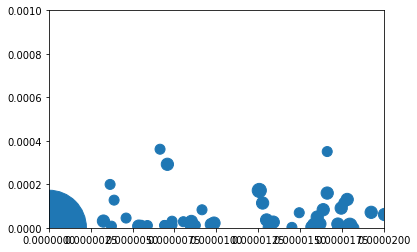

In [320]:
query_term_count_transformer = {}

query_term_distribution_dict_transformer = {} 
print(type(query_term_distribution_dict))
index = 0 

for line in open("transformer.txt"):
    transformer_queries.append(line.strip())
    line_splitted = line.split()
    for term in line_splitted: 
        query_term_count_transformer.setdefault(term.strip().lower(), 1)
        query_term_count_transformer[term.strip().lower()]+=1
    #print(line)
    #query_term_distribution_dict = query_term_distribution_dict.update(query_term_distribution(line.strip())[0])
    query_term_distribution_dict_transformer = {**query_term_distribution_dict_transformer, **query_term_distribution(line.strip())[0]}
    index+=1 
    if index == 50: 
        break
print (len(query_term_distribution_dict_transformer))
p = []
q = []
size_t = []
for key in query_term_distribution_dict_transformer.keys():
    p.append(query_term_distribution_dict_transformer[key][0]/10000)
    q.append(query_term_distribution_dict_transformer[key][1]/10000)
    size_t.append(query_term_count_transformer[key.lower()]*50)
#print(x)
#print(y)
import matplotlib.pyplot as plt
import numpy as np
plt.scatter(p, q, marker='o', s=size_t)
plt.xlim(0, 0.00002)
plt.ylim(0, 0.001)
plt.show()

296


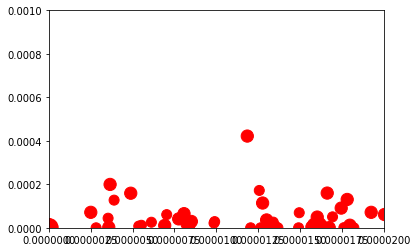

In [321]:
import matplotlib.pyplot as plt
import numpy as np
#print(query_term_count_mtask_transformer)
#print(query_term_count_transformer)
query_term_distribution_dict = {} 
query_term_count_mtask_transformer = {}
index = 0
for line in open("mtask_transformer.txt"):
    transformer_queries.append(line.strip())
    line_splitted = line.split()
    for term in line_splitted: 
        query_term_count_mtask_transformer.setdefault(term.strip().lower(), 1)
        query_term_count_mtask_transformer[term.strip().lower()]+=1
    
    #print(line.strip())
    #query_term_distribution_dict = query_term_distribution_dict.update(query_term_distribution(line.strip())[0])
    query_term_distribution_dict = {**query_term_distribution_dict, **query_term_distribution(line.strip())[0]}
    index+=1
    if index == 50:
        break
x = []
y = []
size_m = []
for key in query_term_distribution_dict.keys():
    x.append(query_term_distribution_dict[key][0]/10000)
    y.append(query_term_distribution_dict[key][1]/10000)
    size_m.append(query_term_count_mtask_transformer[key.lower()] * 50)
#print(x)
#print(y)
print(len(query_term_distribution_dict))
import matplotlib.pyplot as plt
import numpy as np
#plt.scatter(p, q, marker='o', color='black', s=size_t)
plt.scatter(x, y, marker='o', color='red', s=size_m)
  
plt.xlim(0, 0.00002)
plt.ylim(0, 0.001)

plt.show()